In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
frames = np.fromfile('Orion_2022-11-16T16:22:25.503183_0_frames.u8', 'uint8').reshape(-1, 128)
frames.shape

(2303286, 128)

## AOS Primary Headers

The frames are 128-byte AOS Transfer Frames. The Spacecraft ID is 20 (0x1a). This is appears in the SANA registry as [assigned to the spacecraft MPCV](https://sanaregistry.org/r/spacecraftid/records/13806), which stands for multi-purpose crew vehicle (which is the official name of Orion). Virtual channels 1 and 63 (only idle data) are in use.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames[:10]]  # parsing all frames is very slow

# We parse these fields directly rather than with construct
scid = (frames[:, 0] << 2) | (frames[:, 1] >> 6)
vcid = frames[:, 1] & 0x3f
framecount = (frames[:, 2].astype('uint32') << 16) | (frames[:, 3:5].view('uint16').byteswap().ravel())

In [4]:
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=1, virtual_channel_frame_count=1822568, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=1, virtual_channel_frame_count=1822569, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=1, virtual_channel_frame_count=1822570, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=1, virtual_channel_frame_count=1822571, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=1, virtual_channel_frame_count=1822572, replay_flag=False, vc_frame_count_u

In [5]:
collections.Counter(scid)

Counter({20: 2303286})

In [6]:
collections.Counter(vcid)

Counter({1: 1631488, 63: 671798})

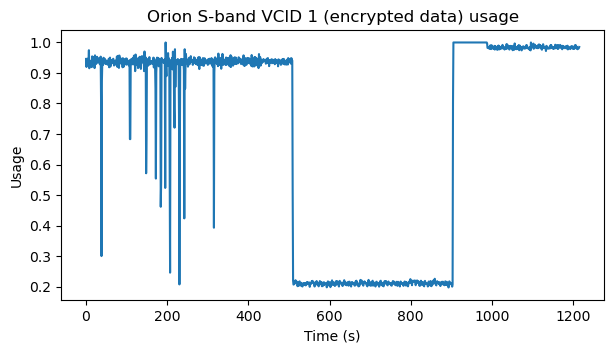

In [7]:
frame_duration = (2048 + 64) / 4e6
frames_per_second = 1 / frame_duration
Navg = round(1 * frames_per_second)
vcid_sec = vcid[:vcid.size//Navg*Navg].reshape(-1, Navg)
t_sec = Navg * frame_duration * np.arange(vcid_sec.shape[0])
vcid_1_usage = np.average(vcid_sec == 1, axis=1)
plt.plot(t_sec, vcid_1_usage)
plt.title('Orion S-band VCID 1 (encrypted data) usage')
plt.xlabel('Time (s)')
plt.ylabel('Usage');

## Virtual channel 63 (OID)

Virtual channel 63 contains idle frames. The 122 bytes of the Transfer Frame Data Field are filled with a counter that counts from `0x00` to `0x79`.

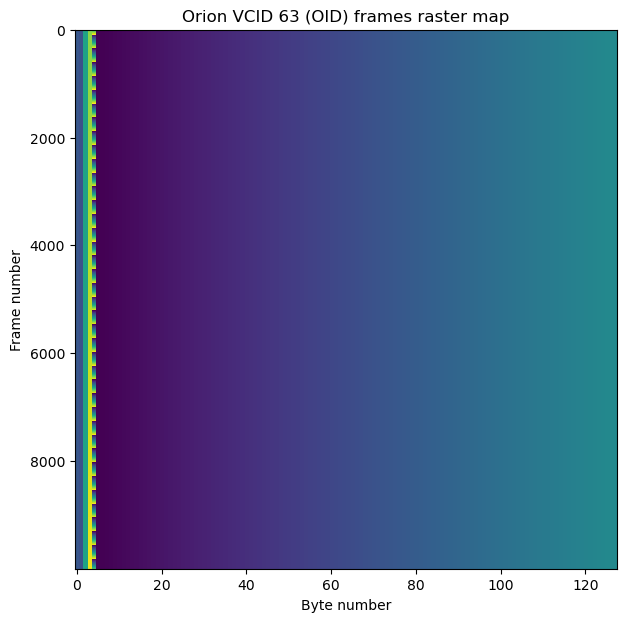

In [8]:
oid_frames = frames[vcid == 63]
plt.figure(figsize=(7, 7))
plt.imshow(oid_frames[:10000], aspect='auto', interpolation='none')
plt.title('Orion VCID 63 (OID) frames raster map')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [9]:
np.all(oid_frames[:, 6:] == np.arange(122))

True

In [10]:
[ccsds.AOSPrimaryHeader.parse(f) for f in oid_frames[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=63, virtual_channel_frame_count=9687724, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=63, virtual_channel_frame_count=9687725, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=63, virtual_channel_frame_count=9687726, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=63, virtual_channel_frame_count=9687727, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=20, virtual_channel_id=63, virtual_channel_frame_count=9687728, replay_flag=False, vc_frame_co

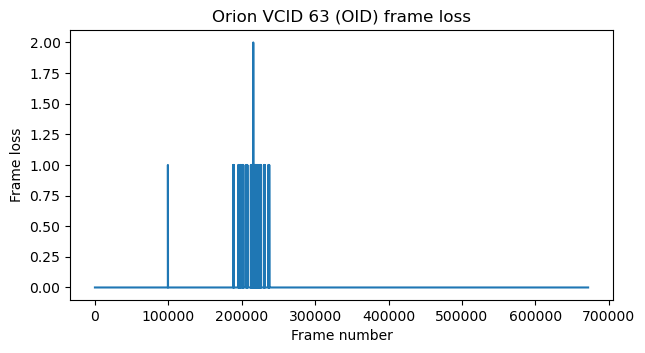

In [11]:
frame_loss = np.diff(framecount[vcid == 63]) - 1
plt.plot(frame_loss)
plt.title('Orion VCID 63 (OID) frame loss')
plt.xlabel('Frame number')
plt.ylabel('Frame loss');

In [12]:
np.sum(frame_loss)

60

In [13]:
np.sum(frame_loss)/(framecount[vcid == 1][-1] - framecount[vcid == 1][0] + 1)

3.6775274266930875e-05

## Virtual Channel 1

Virtual channel 1 contains useful data. The Transfer Frame Data Field contains 4 bytes which seem to be always `0x81010000`, then a 32-bit counter that is ahead of the virtual channel frame counter by `0x02040001` (though arguably some bits (or all of the bits) of the previous 4 bytes could also form part of this counter. The counter is probably an IV for the encrypted data. The rest of the data field (114 bytes) seems to be encrypted.

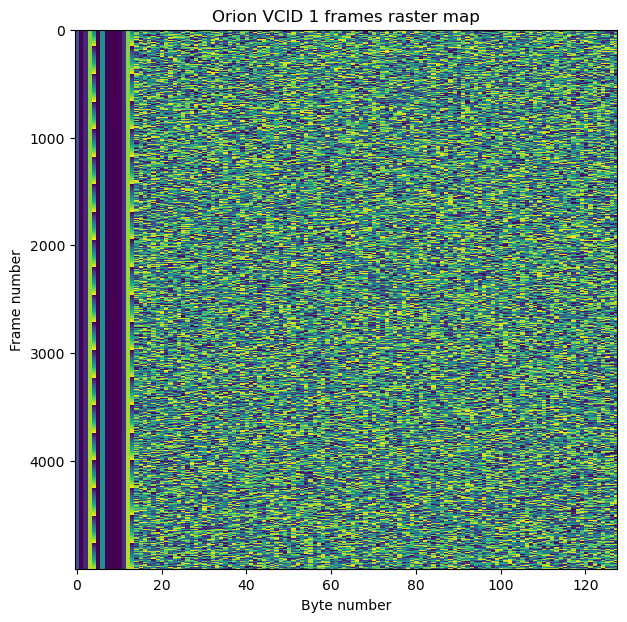

In [14]:
data_frames = frames[vcid == 1]
plt.figure(figsize=(7, 7))
plt.imshow(data_frames[:5000], aspect='auto', interpolation='none')
plt.title('Orion VCID 1 frames raster map')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

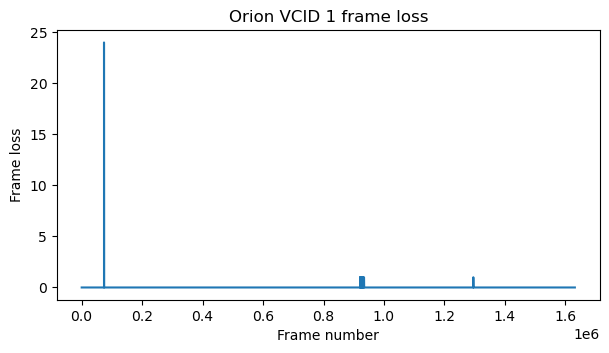

In [15]:
frame_loss = np.diff(framecount[vcid == 1]) - 1
plt.plot(frame_loss)
plt.title('Orion VCID 1 frame loss')
plt.xlabel('Frame number')
plt.ylabel('Frame loss');

In [16]:
np.sum(frame_loss)

43

In [17]:
np.sum(frame_loss)/(framecount[vcid == 1][-1] - framecount[vcid == 1][0] + 1)

2.6355613224633796e-05

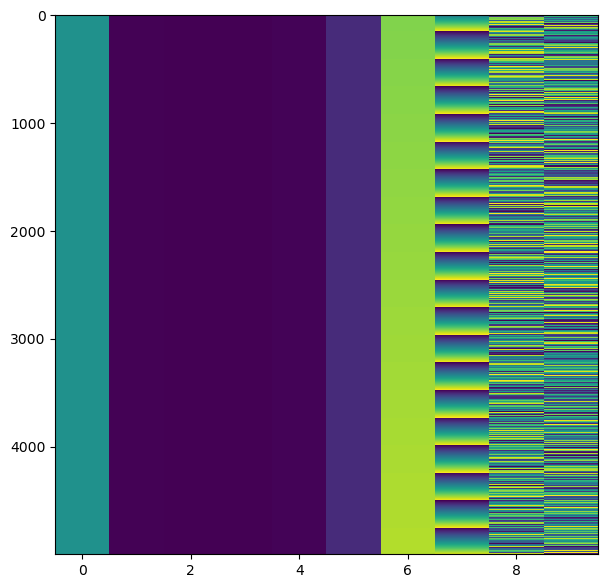

In [18]:
plt.figure(figsize=(7, 7))
plt.imshow(data_frames[:5000, 6:16], aspect='auto', interpolation='none')

In [19]:
counter = data_frames[:, 10:14].view('uint32').byteswap().ravel()
counter_framecount_diff = counter - framecount[vcid == 1]
np.all(counter_framecount_diff == 0x1040001), np.all(counter_framecount_diff == 0x2040001)

(False, True)

In [20]:
np.all(data_frames[:, 6:10] == np.array([0x81, 0x01, 0x00, 0x00]))

True